## Found how to get partial_decompress=True from zarr_python library code, file "build/lib/zarr/tests/test_core.py" test function test_read_nitems_less_than_blocksize_from_multiple_chunks in line 2683

In [1]:
import zarr # Check version
zarr.__version__

'2.13.2'

Zarr Sharding pull request should show '0.0.0'

If it says e.g. 2.13.2, then you're running on the "proper" published version (without Sharding support as of 28-Sept-2022)

<font color="orange">partial_decompress works on current version 2.13, no need for Sharding</font>

### 1. I wanna test partial_decompression by accessing a random index

In [4]:
import numpy as np


numpy_arr = np.empty((65536, 16384), dtype=np.int32) # ~3GB
original_shape = numpy_arr.shape

# 50k x 150k int32 is limit of M1 Pro 32GB
for i in range(numpy_arr.shape[0]):
#     numpy_arr[i][:] = list(range(original_shape[1]*i, original_shape[1]*(i+1)))
    numpy_arr[i][:] = np.random.randint(low=0, high=original_shape[0], size=original_shape[1])

In [5]:
print("Memory used: ", numpy_arr.nbytes / 1024 / 1024 / 1024, " GB")

Memory used:  4.0  GB


In [6]:
numpy_arr[0][0:10]

array([57071, 13148, 30458, 42086, 16973, 17592, 37421, 40209, 46026,
        6304], dtype=int32)

### Following code in zarr test_core.py:2653

In [7]:
# All these extra parameters are irrelevant to _partial_decompress being enabled. Path is enough
# fsstore = zarr.storage.FSStore('./fsstore', key_separator="/", auto_mkdir=True, mode='w', normalize_keys=False)

fsstore = zarr.storage.FSStore('./fsstore4MB')

In [8]:
# chunk_size=(4096,4096)

zarr_index_list = zarr.array(numpy_arr, store=fsstore)#, chunk_store = fsstore_chunk, partial_decompress=True, chunks=chunk_size, dtype='i4')# compressor=weak_compressor, 

In [9]:
zarr_index_list.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [10]:
print("_partial_decompress: ", zarr_index_list._partial_decompress)

_partial_decompress:  False


<font color="orange">As we can see, partial_decompress is False. Don't panic!</font>

In [11]:
# Flush to disk
zarr.save(fsstore, numpy_arr)

In [12]:
# Load from disk

# read_only doesn't affect partial_decompress eligibility
load_partial_decomp = zarr.Array(fsstore, read_only=True, partial_decompress=True)

In [13]:
load_partial_decomp._partial_decompress

True

#### <font color="orange">Solved! Partial_decompress=True</font>

In [14]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [15]:
# del numpy_arr # Don't need this anymore - save 3GB

Sometimes chunks not even initialized? Sometimes 2 arrays are written to disk (i.e. a group). Not sure why

In [16]:
load_partial_decomp[0, 100:105]

array([28904, 43120, 25319, 37625, 47725], dtype=int32)

In [17]:
load_disk_normally = zarr.open(fsstore) # , partial_decompress=True) -- This won't work !!

In [18]:
load_disk_normally._partial_decompress

False

In [19]:
load_disk_normally[0, 100:105]

array([28904, 43120, 25319, 37625, 47725], dtype=int32)

In [20]:
# Do the two match?
(load_partial_decomp[0, 100:105] == load_disk_normally[0, 100:105]).all()

True

### Let's test random access of chunks by index

In [22]:
chunk_shape = (2048, 512)

In [27]:
rand_indices_list = np.random.randint(low=0, high=chunk_shape[0], size=50)

In [28]:
%%timeit
# Read randomly from first chunk, Using partial decompression

for index in rand_indices_list:
    load_partial_decomp[0, index]

39.7 ms ± 4.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for index in rand_indices_list:
    load_disk_normally[0, index]

58.6 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### <font color="orange">Let's access the chunks using 2D accesses now</font>

In [30]:
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [31]:
rand_indices_tuples

(array([ 186, 1502,   61,  632,  467,  552,  368,  319,  120,  143, 1928,
         408, 1720, 1502,  410, 1768,  565,  948, 1486,  425,  410, 1775,
        1086, 1872,  607,  668, 1010,  513,  760, 1706, 1750,  511,  225,
        1192,  541,  440, 1609, 1014, 1511, 1754, 1532, 1560, 1793, 1120,
        1495,   39, 2027, 2015, 1902,  320]),
 array([112, 440,  34, 212, 159, 243, 334, 433, 346, 209, 277, 122,  66,
         91, 448,   0, 183,  46, 196, 446, 355, 211, 407,  98, 420, 308,
        455, 180, 386, 264, 229, 138, 453, 254, 468, 465, 237, 488, 499,
        230, 317, 309,  75, 505,  70, 437,   8, 331, 409, 329]))

In [32]:
rand_indices_tuples[0][1]

1502

TODO set range(50) programmatically

In [33]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

37.8 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

56.2 ms ± 959 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## <font color="orange"> New experiment: access one point per chunk in the whole array</font>

In [69]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(2048, 512)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,2156249432 (2.0G)
Storage ratio,2.0


In [75]:
32**2

1024

In [76]:
from itertools import product

In [81]:
# rand_indices_whole_array = []

xes = []
ys = []

for i in range(32): # there's 32x32 chunks. TODO get programmatically
    # 2d point access - let's not just access first row of chunk
    
    # Random point across all chunks
#     x = np.random.randint(low=i*chunk_shape[0]+5, high=(i+1)*chunk_shape[0] + 5)
#     y = np.random.randint(low=i*chunk_shape[1]+5, high=(i+1)*chunk_shape[1]+5)
    
    xes.append(i*chunk_shape[0]+50)
    ys.append(i*chunk_shape[1]+50)
    
    # "Same" point across all chunks

#     rand_indices_whole_array.append((x,y))
    
    # 1D access - makes indexing complicated
#     rand_indices_whole_array.append(np.random.randint(low=i*chunk_shape[0], high=(i+1)*chunk_shape[1]))

rand_indices_whole_array = list(product(xes, ys))
rand_indices_whole_array

[(50, 50),
 (50, 562),
 (50, 1074),
 (50, 1586),
 (50, 2098),
 (50, 2610),
 (50, 3122),
 (50, 3634),
 (50, 4146),
 (50, 4658),
 (50, 5170),
 (50, 5682),
 (50, 6194),
 (50, 6706),
 (50, 7218),
 (50, 7730),
 (50, 8242),
 (50, 8754),
 (50, 9266),
 (50, 9778),
 (50, 10290),
 (50, 10802),
 (50, 11314),
 (50, 11826),
 (50, 12338),
 (50, 12850),
 (50, 13362),
 (50, 13874),
 (50, 14386),
 (50, 14898),
 (50, 15410),
 (50, 15922),
 (2098, 50),
 (2098, 562),
 (2098, 1074),
 (2098, 1586),
 (2098, 2098),
 (2098, 2610),
 (2098, 3122),
 (2098, 3634),
 (2098, 4146),
 (2098, 4658),
 (2098, 5170),
 (2098, 5682),
 (2098, 6194),
 (2098, 6706),
 (2098, 7218),
 (2098, 7730),
 (2098, 8242),
 (2098, 8754),
 (2098, 9266),
 (2098, 9778),
 (2098, 10290),
 (2098, 10802),
 (2098, 11314),
 (2098, 11826),
 (2098, 12338),
 (2098, 12850),
 (2098, 13362),
 (2098, 13874),
 (2098, 14386),
 (2098, 14898),
 (2098, 15410),
 (2098, 15922),
 (4146, 50),
 (4146, 562),
 (4146, 1074),
 (4146, 1586),
 (4146, 2098),
 (4146, 2610),

In [82]:
len(rand_indices_whole_array) # Should equal n_chunks

1024

In [83]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk

for tup in rand_indices_whole_array:
    load_partial_decomp[tup[0], tup[1]]

898 ms ± 69.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk
# TODO Don't know if my indexing is correct!!

for tup in rand_indices_whole_array:
    load_disk_normally[tup[0], tup[1]]

1.34 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
print("Speedup: ", 1.34 / .9)

Speedup:  1.488888888888889


### <font color="orange">Let's test advanced mask indexing</font>

In [86]:
# Create a 0-1 boolean mask with size same as Whole array
#    Don't know how to do just 1 chunk masking
bool_mask = np.random.randint(low=0, high=2, size=original_shape, dtype=bool)
bool_mask

array([[ True,  True, False, ...,  True,  True, False],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False, False, ...,  True,  True,  True],
       ...,
       [False,  True, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True, False,  True]])

In [87]:
%%timeit
# Partial decompress

# _ to prevent printing
_ = load_partial_decomp.get_mask_selection(bool_mask)

53.1 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit
# NO Partial decompress

# _ to prevent printing
_ = load_disk_normally.get_mask_selection(bool_mask)

56.3 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## <font color="red">Trying 16MB chunks. partial_decompress Benefits should be bigger for bigger chunks</font>

In [93]:
fsstore_8mb = zarr.storage.FSStore("./fsstore16MBChunk")

In [100]:
chunk_shape = (4096,1024) #16MB

In [94]:
zarr_index_list_16MB_Chunk = zarr.array(numpy_arr, store=fsstore_8mb, chunks = chunk_size_8mb)

In [95]:
zarr.save(fsstore_16mb, zarr_index_list_8MB_Chunk)

In [96]:
load_partial_decomp_16mb = zarr.Array(fsstore_16mb, partial_decompress=True)

In [97]:
load_disk_normally_16mb = zarr.Array(fsstore_16mb, partial_decompress=False)

In [101]:
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [102]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp_16mb[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

31.8 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally_16mb[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

112 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## <font color="red">64 MB chunks</font>

In [105]:
fsstore = zarr.storage.FSStore("./fsstore64MBChunk")
chunk_shape = (8192,2048)
zarr_index_list = zarr.array(numpy_arr, store=fsstore, chunks = chunk_shape)
zarr.save(fsstore, zarr_index_list)
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [106]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

31.5 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

425 ms ± 8.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## <font color="red">256MB Chunk</font>

In [110]:
fsstore = zarr.storage.FSStore("./fsstore256MBChunk")
chunk_shape = (16384,4096)
zarr_index_list = zarr.array(numpy_arr, store=fsstore, chunks = chunk_shape)
zarr.save(fsstore, zarr_index_list)
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [2]:
fsstore = zarr.storage.FSStore("./fsstore256MBChunk")

In [7]:
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)

In [9]:
load_partial_decomp._partial_decompress

True

In [111]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

36.7 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

1.62 s ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## <font color="red">1GB Chunk - write then read</font>

In [ ]:
fsstore = zarr.storage.FSStore("./fsstore1GBChunk")
chunk_shape = (32768,8192)
zarr_index_list = zarr.array(numpy_arr, store=fsstore, chunks = chunk_shape)
zarr.save(fsstore, zarr_index_list)
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)
rand_indices_tuples = (np.random.randint(low=0, high=chunk_shape[0], size=50), np.random.randint(low=0, high=chunk_shape[1], size=50))

In [ ]:
%%timeit
# Read randomly from first chunk

for i in range(50):
    load_partial_decomp[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

In [116]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for i in range(50):
    load_disk_normally[rand_indices_tuples[0][i], rand_indices_tuples[1][i]]

6.82 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
xes = []
ys = []

for i in range(2): # N chunks
    xes.append(i*chunk_shape[0]+50)
    ys.append(i*chunk_shape[1]+50)
    

rand_indices_whole_array = list(product(xes, ys))
rand_indices_whole_array

[(50, 50), (50, 8242), (32818, 50), (32818, 8242)]

In [118]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk

for tup in rand_indices_whole_array:
    load_partial_decomp[tup[0], tup[1]]

2.46 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [119]:
%%timeit
# Read randomly from whole array, randomly 1 point from each chunk

for tup in rand_indices_whole_array:
    load_disk_normally[tup[0], tup[1]]

532 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### <font color="red">1. Run for longer than 50, see if serializing only once the big chunk, or every time you index it


2. Figure out decompression unit size. Experiment: Access ranges: 1K, 4K, 16K, 64K - 1M - 16M
</font>

3. Can we change compression size? & tradeoffs w/ different sizes


3. Crossover betw. one at a time IO and loading whole chunks & indexing points. See how many points you need to index for partial_decompress to be slower


4. Mask with sparse, p=0.05

# New Experiments - just read existing data (don't create new FSStores)

In [10]:
import numpy as np
import zarr

# Define data location
fsstore = zarr.storage.FSStore("./fsstore256MBChunk")
# Load data - partial_decompress and full decompress
load_partial_decomp = zarr.Array(fsstore, partial_decompress=True)
load_disk_normally = zarr.Array(fsstore, partial_decompress=False)

In [11]:
load_partial_decomp._partial_decompress

True

In [17]:
load_partial_decomp.info

Type,zarr.core.Array
Data type,int32
Shape,"(65536, 16384)"
Chunk shape,"(16384, 4096)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,4294967296 (4.0G)
No. bytes stored,17334874 (16.5M)
Storage ratio,247.8


<font color="orange">Need the above to determine chunk shape. Don't know how to get that programmatically yet</font>

In [18]:
chunk_shape = (16384,4096)

### Experiment 1: run for longer access (>50)

In [53]:
# Create Random indices to test access speed

index_lengths = range(50,2000,50) # [50, 100, 150 ... 2000]

indices_various_len = []
for ind_len in index_lengths:
    indices_various_len.append(np.array((np.random.randint(low=0, high=chunk_shape[0], size=ind_len), np.random.randint(low=0, high=chunk_shape[1], size=ind_len))).T)

In [54]:
np.info(indices_various_len[0])

class:  ndarray
shape:  (50, 2)
strides:  (8, 400)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x109d25210
byteorder:  little
byteswap:  False
type: int64


In [55]:
indices_various_len[0]

array([[ 4350,   707],
       [ 6420,  2231],
       [ 6202,   867],
       [  805,   645],
       [ 9328,  1212],
       [ 9313,  3034],
       [ 9402,  1465],
       [ 1461,  1608],
       [ 8984,  4092],
       [ 6441,  2719],
       [13419,   315],
       [ 8848,  2826],
       [  591,  2885],
       [15268,  3607],
       [ 6434,    31],
       [15708,   686],
       [ 7005,  1725],
       [13976,   342],
       [ 2763,   509],
       [15908,  1683],
       [15972,  3623],
       [13608,  2889],
       [13205,  1430],
       [ 9280,  1110],
       [14487,  2777],
       [  922,   361],
       [ 5829,  3413],
       [ 5950,  3552],
       [ 4063,  4065],
       [ 4180,   324],
       [15017,  2497],
       [ 7035,  1320],
       [14372,  1172],
       [ 2430,   470],
       [13214,  3788],
       [13340,  2467],
       [12511,  1584],
       [16350,  3010],
       [ 7587,  1893],
       [ 6178,  3837],
       [ 2902,    26],
       [15478,  3451],
       [ 4336,  3892],
       [145

In [56]:
%%timeit
# Read randomly from first chunk, Using partial decompression

for i in range(len(indices_various_len[1])):
    load_partial_decomp[indices_various_len[1][i][0], indices_various_len[1][i][1]]

212 ms ± 7.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
%%timeit
# Read randomly from first chunk, Not using partial decompression

for ind_len in range(len(indices_various_len[1])):
    load_disk_normally[indices_various_len[1][ind_len][0], indices_various_len[1][ind_len][1]]

3.31 s ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
def access_random_indices_chunk(i, loaded_array):
    # Random access of various points in 1 Zarr array chunk
    # This shows the cutoff of how many points-per-chunk makes using
    # partial_decompress=True advantagous
    # Moved to separate function to make %timeit easy
    #
    # Args:
    #    i - how many random accesses to do per chunk (chosen from indices_various_len)
    #    loaded_array - zarr array to access elements from
    test_indices = indices_various_len[i] # For readability
    index_length = indices_various_len[i].shape[0]
    
    for j in range(index_length):
        loaded_array[test_indices[j][0], test_indices[j][1]]

### Below - access times for indices of size 50, 100, 150 ... 2000

#### partial_decompress

In [71]:
partial_decomp_chunk_access = []

for i in range(len(index_lengths)):
    _ = %timeit -o access_random_indices_chunk(i, load_partial_decomp)
    partial_decomp_chunk_access.append(_)

157 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
315 ms ± 9.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
495 ms ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
721 ms ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
903 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
945 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.09 s ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.33 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.39 s ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.63 s ± 94.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.83 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.93 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16 s ± 93.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.17 s ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.33 s ± 22.8 ms per loop (mean ± std. dev. of 7 runs

#### no partial_decompress

In [ ]:
no_decomp_chunk_access = []

for i in range(len(index_lengths[:15])): # Stopped at 15/40 since it's so slow
    _ = %timeit -o access_random_indices_chunk(i, load_disk_normally)
    no_decomp_chunk_access.append(_)

1.81 s ± 46.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.48 s ± 34.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.31 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.3 s ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.08 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.2 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.9 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.8 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.1 s ± 587 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Pickle above results to file - let's not lose experiments

In [ ]:
import pickle

partial_random_chunk_acc_file = open("partial_random_chunk_acc.pickle", 'wb')
normal_random_chunk_acc_file = open("normal_random_chunk_acc.pickle", "wb")

pickle.dump(partial_decomp_chunk_access)
pickle.dump(no_decomp_chunk_access)

### Experiment 1 Plotting

In [76]:
means = [x.average for x in partial_decomp_chunk_access]
stds = [x.stdev for x in partial_decomp_chunk_access]

In [77]:
stds

[0.004598442072913883,
 0.009081079244709946,
 0.04900065314176101,
 0.05229840318444294,
 0.12421336065014245,
 0.021755984297086153,
 0.0094442928403238,
 0.1025880578874397,
 0.006068480490605099,
 0.09407557341539492,
 0.12753523570409298,
 0.10931725902482747,
 0.09305288844306654,
 0.0037340868973195114,
 0.022760713017623904,
 0.06842173643440884,
 0.08429396828361521,
 0.030376865680653113,
 0.08196310305262813,
 0.01863328268705259,
 0.06172907405050216,
 0.15907518010697402,
 0.1550881229666915,
 0.09425172934937888,
 0.11030702312275065,
 0.17042800628047736,
 0.30414712856626713,
 0.13092133431603725,
 0.01587122892079038,
 0.01596054154167808,
 0.017754056586481888,
 0.012454242976674303,
 0.12098796405862741,
 0.18228777546139163,
 0.003310903646632827,
 0.12890598446098026,
 0.2799352919151161,
 0.055008405447071064,
 0.16218673143409068]

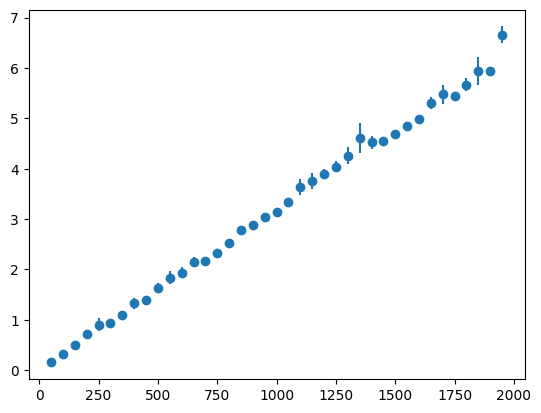

In [78]:
import matplotlib.pyplot as plt
# x = [1, 2, 3, 4]
# y = [1, 4, 9, 16]
# e = [0.5, 1., 1.5, 2.]
plt.errorbar(index_lengths, means, yerr=stds, fmt='o')
plt.show()

### Experiment 2 - Stabbing queries